In [0]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import files

In [0]:
# Code to read csv file into colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [12]:
# Obtain position array
link = 'https://drive.google.com/open?id=17uhjHgOZHNIoqzcTUry8d88XotPr9-qz' # Add link to position array file

fluff, id = link.split('=')
#print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('pos_array_100k.npy') 
pos_array = np.load('pos_array_100k.npy')
pos_array.shape

(100000, 30, 3)

The first 1000 snapshots in the trajectory are really bad, so these must be disgarded. 

In [0]:
pos_array = pos_array[1000:,:,:]

In [0]:
def mean_sorting(pos, n_train):
    """mean_sorting
    Take position array from the atoms_to_array function, and sort atoms
    by their mean position to the origin

    :param pos: (n_train, n_atoms, 3) array obtained from atoms_to_array
    :param n_train: number of snapshots used for sorting
    :return numpy array of dimension (n_train, n_atoms, 3)
    """

    mean_xyz = np.mean(pos[0:n_train], axis=0)
    mean_dist = np.linalg.norm(mean_xyz, axis=1)

    pos_mean_sort = []
    putting_sequence = []

    for i in range(len(pos)):
        pos_snap_i = pos[i]
        pos_mean_sort = pos_snap_i[mean_dist.argsort()]
        putting_sequence.append(pos_mean_sort)

    return putting_sequence

def original_sorting(pos):    
    putting_sequence = []
    
    for i in range(len(pos)):
        xyz = pos[i]
        dist = np.linalg.norm(xyz, axis = 1) # compute distance to origin
        pos_sorted = xyz[dist.argsort()] # sort the atoms by their distances
        putting_sequence.append(pos_sorted)
        
    return putting_sequence

def gaussian_expansion(input_array, n_grid_points, sigma, n_train, n_type):
    """gaussian expansion
    Expand the last dimension of input array such that an extra dimension
    of size n_grid is added.
    The extra dimension is a smoothed one-hot encoding of the scalar values
    of the last dimension.

    :param input_array: use sorted_pos_arrray
    :n_grid_points: Number of grid points, i.e. resolution of the gaussain expansion
    :sigma: Kernel parameter for density smoothing
    :n_train: size of the expanded array
    :n_type: number of atom types, default = 1
    :return expanded_array
    """
    x_grid = np.linspace(0,10,n_grid_points + 1)

    pos_matrix = input_array[:n_train] # the sequence with n training examples
    d = x_grid[:-1]+(x_grid[1]-x_grid[0])/2 # taking mid value of linspace
    d = np.tile(d,(n_type,1)) # concatenate n_type column
    d = np.transpose(d) # make it dim(n_grid_points,n_type)

    # obtain n_atoms from first snapshot
    n_atoms = len(pos_matrix[0])

    # initialize density matrix
    density_matrix = np.zeros((n_train, n_atoms), object)

    for i in range(n_train):
        for j in range(n_atoms):
            density_matrix[i][j] = np.exp(-(np.abs(d-pos_matrix[i][j])**2) / (2*sigma**2))

    expanded_array = density_matrix.tolist() # list converting
    return expanded_array

def normalize_density(density_matrix):
    """normalize_density
    :param density_matrix: the unormalized density matrix
    :return normalized density matrix
    """
    n_snaps = len(density_matrix[:,0,0,0]) # obtain snapshots
    n_atoms = len(density_matrix[0,:,0,0]) # obtain number of atoms

    norm_dens_matrix = np.zeros_like(density_matrix)

    for i in range(n_snaps):
        for j in range(n_atoms):
            norm_dens_matrix[i,j,:,:] = preprocessing.normalize(density_matrix[i, j, :, :], norm='l1', axis=0)

    return norm_dens_matrix

In [0]:
# Set parameters
n_grid_points = 50
sigma = 0.2
n_train = 50000
n_type = 1

pos_array_sorted = mean_sorting(pos_array, 40000)
#pos, putting_sequence = atoms_to_array(pos_array, n_train)
#pos_array_sorted = original_sorting(pos_array)
density_matrix_aslist = gaussian_expansion(pos_array_sorted, n_grid_points, sigma, n_train, n_type)

In [0]:
density_matrix = np.asarray(density_matrix_aslist)

# Visualizing density data

In [0]:
#density_matrix = normalize_density(density_matrix)

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <a list of 10 Text yticklabel objects>)

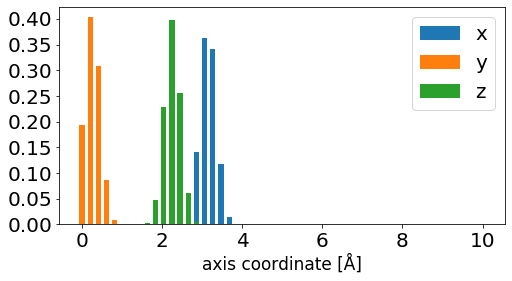

In [18]:
(fig, ax) = plt.subplots(figsize=(8,4))
ax.bar(np.linspace(0,10,n_grid_points),density_matrix[0,2,:,0]/np.sum(density_matrix[0,2,:,0]), width=0.13) #,'--', linewidth=3)
ax.bar(np.linspace(0,10,n_grid_points),density_matrix[0,2,:,1]/np.sum(density_matrix[0,2,:,1]), width=0.13) #,'--', linewidth=3)
ax.bar(np.linspace(0,10,n_grid_points),density_matrix[0,2,:,2]/np.sum(density_matrix[0,2,:,2]), width=0.13) #,'--', linewidth=3)
plt.xlabel("axis coordinate [Å]", fontsize=17)
plt.legend(["x","y","z"], fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('input_rep.eps',bbox_inches='tight')

In [0]:
#files.download('input_rep.eps')

In [20]:
print('The projection of the density of the first atom in the first snapshot onto each of the three axes:')
print(density_matrix[0,0,0:15,:])

The projection of the density of the first atom in the first snapshot onto each of the three axes:
[[2.43089237e-05 1.22465904e-04 8.52791052e-52]
 [1.48110471e-03 5.17856182e-03 2.36528548e-45]
 [3.31979536e-02 8.05579964e-02 2.41340392e-39]
 [2.73742596e-01 4.61013524e-01 9.05903589e-34]
 [8.30383991e-01 9.70564031e-01 1.25094860e-28]
 [9.26661399e-01 7.51692535e-01 6.35480850e-24]
 [3.80424690e-01 2.14171560e-01 1.18760219e-19]
 [5.74542072e-02 2.24485804e-02 8.16479016e-16]
 [3.19212945e-03 8.65608438e-04 2.06502153e-12]
 [6.52446149e-05 1.22789039e-05 1.92136405e-09]
 [4.90585115e-07 6.40771570e-08 6.57658221e-07]
 [1.35703041e-09 1.23013390e-10 8.28125895e-05]
 [1.38092570e-12 8.68774490e-14 3.83617132e-03]
 [5.16959549e-16 2.25718549e-17 6.53740125e-02]
 [7.11948090e-20 2.15741135e-21 4.09843270e-01]]


# Partitioning the dataset

In [0]:
snapshots = []
for i in range(density_matrix.shape[0]):
  snap = density_matrix[i, : , : , :]
  snap_axes_flipped = np.moveaxis(snap, source=[0,1,2], destination=[0,2,1])
  snap_reshaped = np.reshape(snap_axes_flipped, (90, n_grid_points))
  snapshots.append(snap_reshaped)
#plt.plot(snapshots[0][70,:]); len(snapshots)

In [22]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

def create_datasets(snapshots, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(snapshots)*p_train)
    num_val = int(len(snapshots)*p_val)
    num_test = int(len(snapshots)*p_test)

    # Split sequences into partitions
    snapshots_train = snapshots[:num_train]
    #random.shuffle(snapshots_train) #shuffle method

    snapshots_val = snapshots[num_train:num_train+num_val]
    snapshots_test = snapshots[-num_test:]

    def get_inputs_targets_from_snapshots(snapshots):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 atoms of a snapshot of length L
        # but targets are shifted right by one so that we can predict the next atom
        for snap in snapshots:
            inputs.append(snap[:-1,:])
            targets.append(snap[1:,:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_snapshots(snapshots_train)
    inputs_val, targets_val = get_inputs_targets_from_snapshots(snapshots_val)
    inputs_test, targets_test = get_inputs_targets_from_snapshots(snapshots_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(snapshots, Dataset)

print(f'We have {len(training_set)} snapshots in the training set.')
print(f'We have {len(validation_set)} snapshots in the validation set.')
print(f'We have {len(test_set)} snapshots in the test set.')

We have 40000 snapshots in the training set.
We have 5000 snapshots in the validation set.
We have 5000 snapshots in the test set.


In [23]:
training_set.inputs[0].shape

(89, 50)

# Create one-hot-encoding

In [0]:
def one_hot_encode(idx, input_dim):
    """
    One-hot encodes an atom given its index and the input dimension.

    :param `idx`: the index of the given interval
    :param `input_dim`: the number of intervals in x_grid
    :return 1-D numpy array of length `input_dim`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(input_dim)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_snapshot(snapshot, input_dim):
    """
    One-hot encodes a snapshot of atoms given a fixed input dimension.
    
     :param `snapshot`: a snapshot of atoms to encode
     :param `input_dim`: the number of intervals in x_grid
     :return 3-D numpy array of shape (num atoms, input size, 1).
    """
    # Encode each atom coordinate in the snapshot
    encoding = np.array([one_hot_encode(np.argmax(snapshot[i,:]), input_dim) for i in range(snapshot.shape[0])])

    # Reshape encoding s.t. it has shape (num atoms, input size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding

In [25]:
one_hot_encode_snapshot(training_set.inputs[0], n_grid_points).shape

(89, 50, 1)

# Create density plotting function

In [0]:
def PlotComparison(inputs, targets, test_or_train, net, model_type):
    # One-hot encode input snapshot
    inputs_one_hot = one_hot_encode_snapshot(inputs, input_dim) # dim(89,50,1)

    if model_type=='axis':
      x_index = np.arange(0,89,3)
      y_index = np.arange(1,89,3)
      z_index = np.arange(2,89,3)
      inputs_one_hot[x_index,n_grid_points+0,:] = 1
      inputs_one_hot[y_index,n_grid_points+1,:] = 1
      inputs_one_hot[z_index,n_grid_points+2,:] = 1
    elif model_type=='atom':
      for indiana_jones in range(89):
        inputs_one_hot[indiana_jones,n_grid_points+indiana_jones,:] = 1
    # if model_type = vanilla, we do no concatenation

    # Convert input to tensor
    inputs_one_hot = torch.Tensor(inputs_one_hot)
    inputs_one_hot = inputs_one_hot.permute(0, 2, 1) # dim(89,50,1) -> dim(89,1,50)

    # Convert target to tensor
    #targets = np.argmax(targets, axis=1) # if CrossEntropy
    targets = torch.FloatTensor(targets)
    #targets = targets.long()             # if CrossEntropy

    # Forward pass
    outputs = net.forward(inputs_one_hot).data.numpy()

    # Get index of x and y coordinates
    x_index29 = np.arange(3,89,3)
    y_index29 = np.arange(4,89,3)
    x_dens_input = targets[x_index29,:]
    y_dens_input = targets[y_index29,:]

    # Plot target
    xy_dens_input = np.zeros((n_grid_points,n_grid_points))
    for i in range(len(x_dens_input)):
      xy_dens_input += np.outer(x_dens_input[i,:], y_dens_input[i,:])

    f, (ax1, ax2)  =  plt.subplots(1,2 , figsize=(16,6), tight_layout=True)
    im1 = ax1.imshow(xy_dens_input, cmap='viridis')
    plt.colorbar(im1,ax=ax1)
    ax1.set_title(test_or_train + ':  Target snapshot', fontsize=20)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    # Plot prediction
    x_dens = outputs[x_index29,:]
    y_dens = outputs[y_index29,:]
    xy_dens = np.zeros((n_grid_points,n_grid_points))
    for i in range(len(x_dens)):
      xy_dens += np.outer(x_dens[i,:], y_dens[i,:])

    im2 = ax2.imshow(xy_dens, cmap='viridis')
    plt.colorbar(im2,ax=ax2)
    ax2.set_title(test_or_train + ':  Predicted snapshot', fontsize=20)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.show()

# LSTM

In [0]:
# Hyper-parameters
num_epochs = 1
model_type = 'atom'

if model_type=='axis':
  const=3
elif model_type=='atom':
  const=89

# if model_type = vanilla, we do no concatenation
# Inputs to network
input_dim = len(density_matrix[0,0,:,0])  + const
hidden_size = 256

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Recurrent layer
        self.lstm = nn.LSTM(input_dim, hidden_size, #bidirectional=True, 
                            batch_first=True, num_layers=2, dropout=0.5)
        
        # Output layer
        #self.layer_out1 = 100
        #self.l_out1 = nn.Linear(in_features=hidden_size,
        #                    out_features=self.layer_out1,
        #                    bias=True)
        
        self.l_out2 = nn.Linear(in_features=hidden_size,
                    out_features=input_dim-const,
                    bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        x, (h, c)  = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)
        
        x = F.relu(x)
        
        # Output layer
        #x = self.l_out1(x)
        #x = F.relu(x)
        
        x = self.l_out2(x)
        x = torch.sigmoid(x)
        #x = F.softmax(x, dim=0) # works really bad for some reason

        return x

net = Net()
print(net)

Net(
  (lstm): LSTM(139, 256, num_layers=2, batch_first=True, dropout=0.5)
  (l_out2): Linear(in_features=256, out_features=50, bias=False)
)


# Training

In [0]:
# Initialize network
net = Net()

In [0]:
# Define loss function and optimizer
import torch.optim as optim
from torch.nn.parameter import Parameter
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95) # Not applicable here!
optimizer = optim.RMSprop(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)

Training sample number 2500/40000
Training sample number 5000/40000
Training sample number 7500/40000
Training sample number 10000/40000
Training sample number 12500/40000
Training sample number 15000/40000
Training sample number 17500/40000
Training sample number 20000/40000
Training sample number 22500/40000
Training sample number 25000/40000
Training sample number 27500/40000
Training sample number 30000/40000
Training sample number 32500/40000
Training sample number 35000/40000
Training sample number 37500/40000
Training sample number 40000/40000
Epoch 0, training loss: 0.001311538214816028, validation loss: 0.23619855498969555


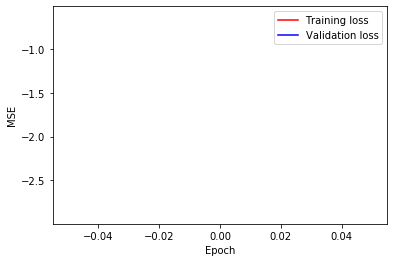

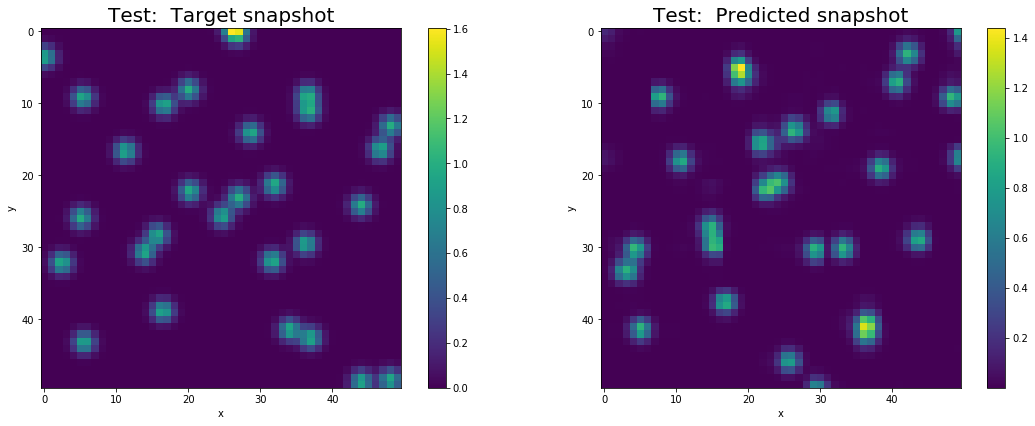

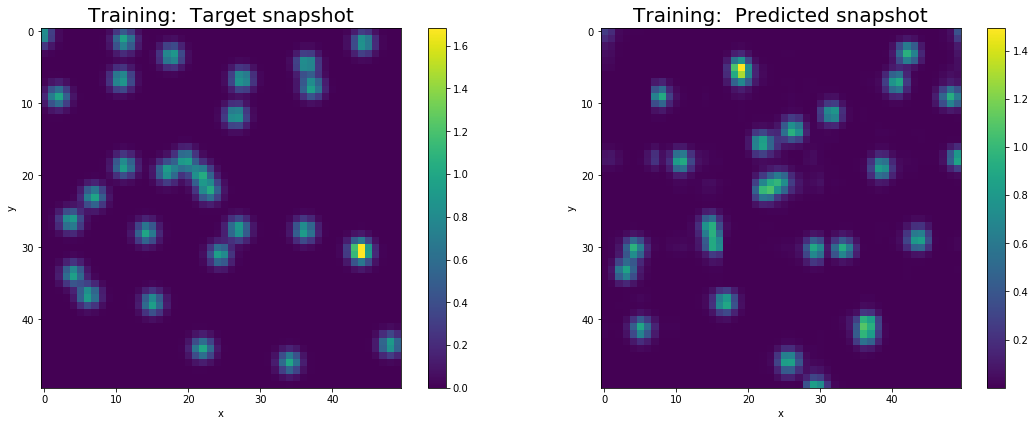

In [31]:
x_index = np.arange(0,89,3)
y_index = np.arange(1,89,3)
z_index = np.arange(2,89,3)

# Track loss
training_loss, validation_loss = [], [] # comment out to continue a previous training run

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # Enrich dataset
    #training_set, validation_set, test_set = create_datasets(snapshots, Dataset, )

    net.eval()
    # For each snapshot in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input snapshot
        inputs_one_hot = one_hot_encode_snapshot(inputs, input_dim) # dim(89,50,1)

        for indiana_jones in range(89):
            inputs_one_hot[indiana_jones,n_grid_points+indiana_jones,:] = 1
        
        if model_type=='axis':
            x_index = np.arange(0,89,3)
            y_index = np.arange(1,89,3)
            z_index = np.arange(2,89,3)
            inputs_one_hot[x_index,n_grid_points+0,:] = 1
            inputs_one_hot[y_index,n_grid_points+1,:] = 1
            inputs_one_hot[z_index,n_grid_points+2,:] = 1
        elif model_type=='atom':
            for indiana_jones in range(89):
                inputs_one_hot[indiana_jones,n_grid_points+indiana_jones,:] = 1
        # if model_type = vanilla, we do no concatenation


        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1) # dim(89,50,1) -> dim(89,1,50)
        
        # Remove these two # for CrossEntropy
        #targets = np.argmax(targets, axis=1) # if CrossEntropy
        targets = torch.FloatTensor(targets)
        #targets = targets.long()             # if CrossEntropy

        # Run forward pass
        outputs = net(inputs_one_hot) # dim(89,50)
        # Compute loss
        loss = criterion(outputs, targets)
        # Update loss
        epoch_validation_loss += loss.detach().numpy()

    net.train()
    # For each snapshot in training set
    my_counter=0
    for inputs, targets in training_set:
        # One-hot encode input snapshot
        inputs_one_hot = one_hot_encode_snapshot(inputs, input_dim) # dim(89,50,1)
     
        if model_type=='axis':
          x_index = np.arange(0,89,3)
          y_index = np.arange(1,89,3)
          z_index = np.arange(2,89,3)
          inputs_one_hot[x_index,n_grid_points+0,:] = 1
          inputs_one_hot[y_index,n_grid_points+1,:] = 1
          inputs_one_hot[z_index,n_grid_points+2,:] = 1
        elif model_type=='atom':
          for indiana_jones in range(89):
              inputs_one_hot[indiana_jones,n_grid_points+indiana_jones,:] = 1
        # if model_type = vanilla, we do no concatenation


        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1) # dim(89,50,1) -> dim(89,1,50)

        #targets = np.argmax(targets, axis=1)  # if CrossEntropy
        targets = torch.FloatTensor(targets)
        #targets = targets.long()              # if CrossEntropy


        # Run forward pass
        outputs = net(inputs_one_hot) # dim(89,50)
        # Compute loss
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update loss
        epoch_training_loss += loss.detach().numpy()

        my_counter += 1
        if my_counter % 2500 == 0:
          print('Training sample number ' + str(my_counter) + '/' + str(len(training_set)))

    net_save = net
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))
    # Print loss every 5 epochs
    if i % 1 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


####################################################################
##############   Plot training and validation loss  ################
####################################################################

epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch[0:], np.log10(training_loss[0:]), 'r', label='Training loss',)
plt.plot(epoch[0:], np.log10(validation_loss[0:]), 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('MSE')
plt.show()

####################################################################
################# Test out-of-sample predictions ###################
####################################################################

inputs, targets = test_set[0]
PlotComparison(inputs, targets, 'Test', net, model_type=model_type)

####################################################################
################### Test in-sample predictions #####################
####################################################################

inputs, targets = training_set[0]
PlotComparison(inputs, targets, 'Training', net, model_type=model_type)

Evalute validation performance one last time:

In [0]:
epoch_training_loss = 0
epoch_validation_loss = 0
net.eval()
for inputs, targets in validation_set:
    inputs_one_hot = one_hot_encode_snapshot(inputs, input_dim) # dim(89,50,1)
    inputs_one_hot = torch.Tensor(inputs_one_hot)
    inputs_one_hot = inputs_one_hot.permute(0, 2, 1) # dim(89,50,1) -> dim(89,1,50)
    #targets = np.argmax(targets, axis=1)  # if CrossEntropy
    targets = torch.FloatTensor(targets)
    #targets = targets.long()              # if CrossEntropy
    outputs = net(inputs_one_hot) # dim(89,50)
    loss = criterion(outputs, targets)
    epoch_validation_loss += loss.detach().numpy()
validation_loss.append(epoch_validation_loss/len(validation_set))

In [33]:
validation_loss

[0.23619855498969555, 0.06589881677031517]

# Structure generation



In [0]:
def GenerateStructures(n_structures, net, training_set):
  
  structures_array = []

  for k in range(n_structures):
    # Initialize structure by copying training set snapshot
    inputs, targets = training_set[0]
    inputs_one_hot = one_hot_encode_snapshot(inputs, input_dim) # dim(89,50,1) 
    
    # Fill up "long-memory-input" with -1 padding
    #inputs_one_hot[:,50+89:,:] = -1*np.ones((89,5,1))
    
    
    p_x0 = np.sum(density_matrix[0:len(training_set),0,:,0], axis=0)
    p_x0 = p_x0/np.sum(p_x0)

    x0 = int(np.random.choice(n_grid_points,1, p=p_x0))
    inputs_one_hot[0, 0:n_grid_points , 0] = one_hot_encode(x0, input_dim -1*89)      ### Her skal der ændres dimension!
    new_structure = np.zeros(90)
    new_structure[0]=x0
    
    # Initialize "long-memory-input" by setting first row manually
    #inputs_one_hot[2,50+89,:] = np.argmax(inputs_one_hot[0,0:50, 0])

    if model_type=='axis':
      x_index = np.arange(0,89,3)
      y_index = np.arange(1,89,3)
      z_index = np.arange(2,89,3)
      inputs_one_hot[x_index,n_grid_points+0,:] = 1
      inputs_one_hot[y_index,n_grid_points+1,:] = 1
      inputs_one_hot[z_index,n_grid_points+2,:] = 1
    elif model_type=='atom':
      for indiana_jones in range(89):
          inputs_one_hot[indiana_jones,n_grid_points+indiana_jones,:] = 1
    # if model_type = 'vanilla', we do no concatenation


    # Convert input to tensor
    inputs_one_hot_torch = torch.Tensor(inputs_one_hot)
    inputs_one_hot_torch = inputs_one_hot_torch.permute(0, 2, 1) # dim(89,50,1) -> dim(89,1,50)
    # Forward pass
    outputs = net.forward(inputs_one_hot_torch).data.numpy()
    #outputs = F.softmax(net.forward(inputs_one_hot_torch), dim=0).data.numpy()

    for i in range(0,outputs.shape[0]-1):
      # Get next density from LSTM output
      dist_new = outputs[i,:]
      # Normalize to probability distribution
      dist_new /= np.sum(dist_new)
      # Draw random variable from 1-d density distribution
      new_atom_coordinate = int(np.random.choice(n_grid_points,1, p=dist_new))
      # Add to generated atomic structure
      new_structure[i+1]=new_atom_coordinate
      
      # To do: write stochastic resampling function for too closely placed atoms:
      #if z_index[i+1]==TRUE:
      #    distances = calc_distances(new_structure[0:i+1])
      #    too_close = check_proximity(new_structure[0:i+1])
      #    if min(distances)<2:

      # Update input array to LSTM
      inputs_one_hot[i+1, 0:n_grid_points , 0] = one_hot_encode(new_atom_coordinate, input_dim -1*89)  ### Her skal der ændres dimension!

      inputs_one_hot_torch = torch.Tensor(inputs_one_hot)
      inputs_one_hot_torch = inputs_one_hot_torch.permute(0, 2, 1) # dim(89,50,1) -> dim(89,1,50)
      # Forward pass
      outputs = net.forward(inputs_one_hot_torch).data.numpy()
      #outputs = outputs = F.softmax(net.forward(inputs_one_hot_torch), dim=0).data.numpy()

    # Last prediction (i.e. of z_29)
    i += 1
    dist_new = outputs[i,:]
    dist_new /= np.sum(dist_new)
    new_atom_coordinate = int(np.random.choice(n_grid_points,1, p=dist_new))
    new_structure[i+1]=new_atom_coordinate
    new_structure = np.reshape(new_structure, (30, 3))
    
    structures_array.append(new_structure)
    
    if k % 50 == 0:
        print('Structures generated:  ' + str(k)+'/'+str(n_structures))
  
  return structures_array

In [0]:
#structures_array = GenerateStructures(2000, net_save, training_set)
#np.save('axis_structure250.npy', new_structure)
#np.save('structures_array.npy', np.asarray(structures_array))
#files.download('axis_structure250.npy')

Structures generated:  0/250
Structures generated:  50/250
Structures generated:  100/250
Structures generated:  150/250
Structures generated:  200/250


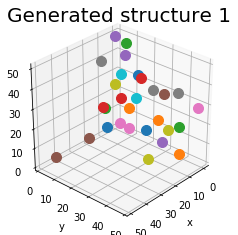

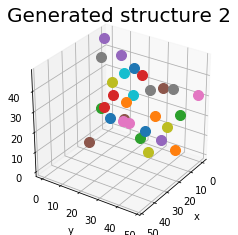

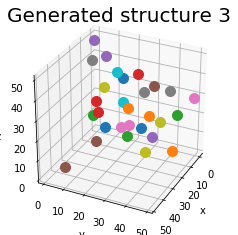

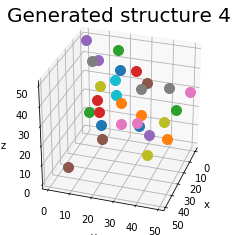

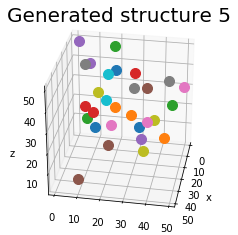

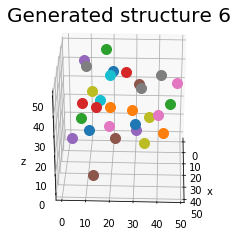

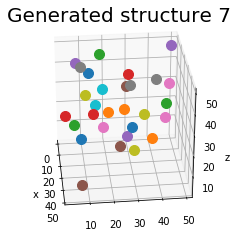

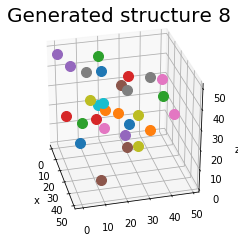

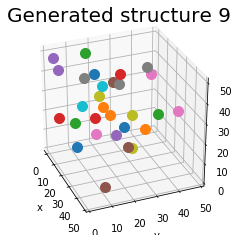

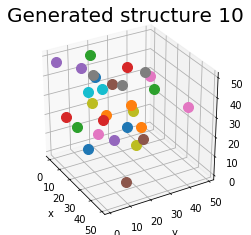

In [36]:
def Plot3dDensity(new_structure, angle, number):
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure(figsize=(4,4))
  ax = fig.add_subplot(111, projection='3d')
  ax.view_init(None, angle)
  ax.set_facecolor('white')
  ax.grid(color='black', linestyle='-', linewidth=0.1)
  for i in range(29):
    ax.scatter(new_structure[i,0], new_structure[i,1], new_structure[i,2], zdir='z', s=100)
    #ax.text(new_structure[i,0], new_structure[i,1], new_structure[i,2]+2, str(i), fontsize=10)
  ax.set_xlabel('x', fontsize=10)
  ax.set_ylabel('y', fontsize=10)
  ax.set_zlabel('z', fontsize=10)
  ax.set_title('Generated structure '+ str(number),fontsize=20)

n_structures = 250
new_structure = GenerateStructures(n_structures, net_save, training_set)
number=0
for structure in np.arange(0,10, 1):
  number += 1
  for angle in range(30, 31, 30):
    Plot3dDensity(new_structure[structure], 20+angle-8*number, number)
# maybe add projection onto axes

# Distribution in atom coordinate location of the generated sample

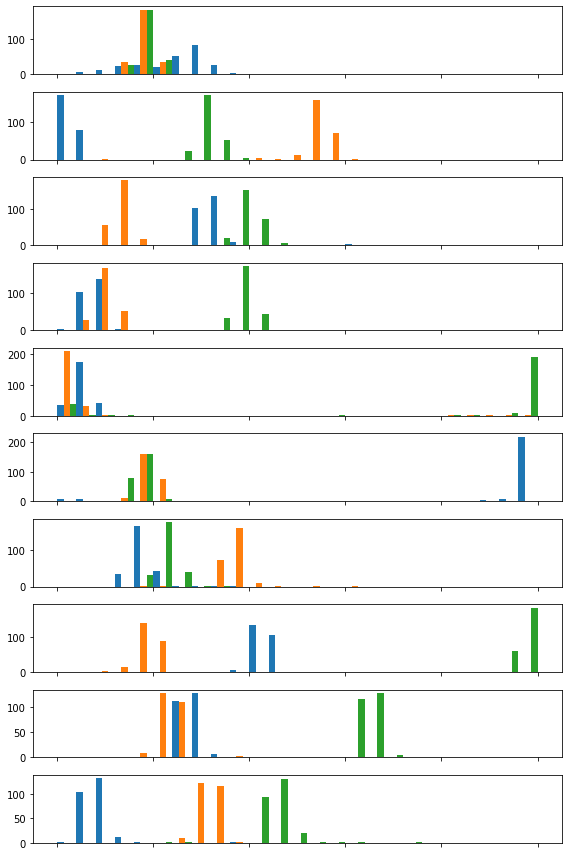

In [37]:
np_structure = np.asarray(new_structure)

f, ax  =  plt.subplots(10,1 , figsize=(8,12), tight_layout=True)
for i in range(0,10):
  ax[i].hist(np_structure[:,i,0:3], bins=np.linspace(0,50,26), alpha=1.0, rwidth=50)
  ax[i].minorticks_off()
  plt.setp( ax[i].get_xticklabels(), visible=False)
  plt.subplots_adjust(hspace=-0.9)

f.tight_layout(h_pad=5, w_pad=0)
#plt.hist(new_structure[:][10][0:1])

# Mean distance to origin as a function of atom number

Text(0, 0.5, 'Distance to origin [Å]')

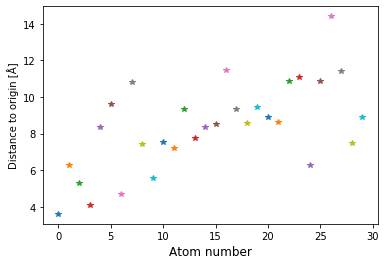

In [38]:
dist_mean = np.zeros(30)
for i in range(30):
  for k in range(n_structures):
    dist_mean[i] += np.linalg.norm(new_structure[k][i,:]*0.2+0.1)/n_structures

#plt.plot(i, np.linalg.norm(new_structure[k][i,:]),'*')
for i in range(30):
    plt.plot(i, dist_mean[i],'*')

plt.xlabel('Atom number', fontsize=12)
plt.ylabel('Distance to origin [Å]')

# Radial distribution function

In [39]:
# Generate crystal of 3*3*3 unit cells
dist_all_structures = []
for l in range(n_structures):
  crystal27 = np.zeros((27*30,3))
  crystal27[0:30,:] = new_structure[l][:,:] + n_grid_points*np.ones((30,3))
  cell_count = 1
  for x in range(0,3):
    for y in range(0,3):
      for z in range(0,3):
        if x==1 and y==1 and z==1:
          continue
        extra_stuff = np.zeros((30,3))
        extra_stuff[:,0] = x; extra_stuff[:,1] = y; extra_stuff[:,2] = z;
        extra_stuff *= n_grid_points
        extra_unit_cell = new_structure[l][:,:] + extra_stuff
        crystal27[30*cell_count:30*(cell_count+1),:] = extra_unit_cell
        cell_count += 1
  
  # Calculate distances between all atom pairs in crystal
  dist_array = np.zeros((30, crystal27.shape[0]-1))
  for i in range(0,30): # each atom in the center unit cell of the crystal
    dist_array_i = np.zeros(crystal27.shape[0])
    for j in range(0, crystal27.shape[0]): # all other atoms in the crystal
      if i == j:
        continue
      dist_array_i[j] = np.linalg.norm((crystal27[i,:]*10/n_grid_points+0.5*10/n_grid_points)-(crystal27[j,:]*10/n_grid_points+0.5*10/n_grid_points))
    dist_array[i,:] = np.delete(dist_array_i, i)
  # Keep only distances smaller than 10 Ångstrom.
  dist_less_10 = dist_array[dist_array < 10]
  dist_all_structures = np.concatenate((dist_all_structures, dist_less_10))
  if l % 10 == 0:
        print('Structures completed:  ' + str(l)+'/'+str(n_structures))

Structures completed:  0/250
Structures completed:  10/250
Structures completed:  20/250
Structures completed:  30/250
Structures completed:  40/250
Structures completed:  50/250
Structures completed:  60/250
Structures completed:  70/250
Structures completed:  80/250
Structures completed:  90/250
Structures completed:  100/250
Structures completed:  110/250
Structures completed:  120/250
Structures completed:  130/250
Structures completed:  140/250
Structures completed:  150/250
Structures completed:  160/250
Structures completed:  170/250
Structures completed:  180/250
Structures completed:  190/250
Structures completed:  200/250
Structures completed:  210/250
Structures completed:  220/250
Structures completed:  230/250
Structures completed:  240/250


Text(4, 400, '0.3164856756899002')

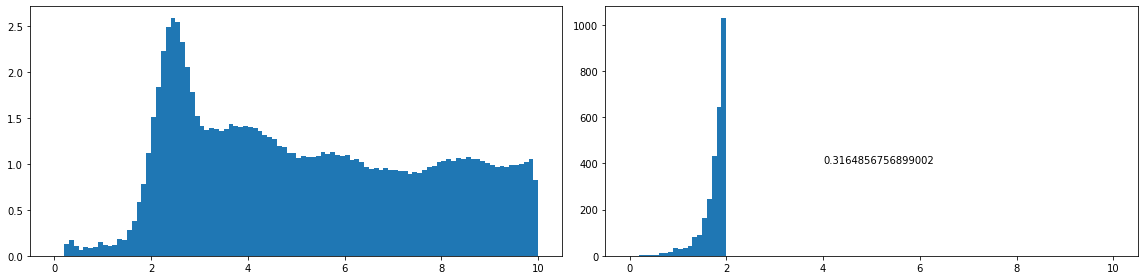

In [40]:
dist_all_structures_noise = dist_all_structures + np.random.uniform(-0.1,0.1, size=len(dist_all_structures))
hist, bin_edges = np.histogram(dist_all_structures_noise, bins=np.linspace(0,10,101))
bin_mid_points = bin_edges[:-1]+0.05
# The radial distribution function must be altered take into account the volume of a spherical shell at distance r.
count_multiplier = 1/(4*np.pi*(bin_mid_points+0.0)**2)
#count_multiplier[0:10] = 0.0001*hist[0:10]
f, (ax1, ax2)  =  plt.subplots(1,2 , figsize=(16,4), tight_layout=True)
ax1.bar(bin_edges[:-1]+0.05, count_multiplier*hist/np.mean(count_multiplier[95:98]*hist[95:98]), width=0.1)
hist2, bin_edges2 = np.histogram(dist_all_structures_noise[dist_all_structures_noise<2], bins=np.linspace(0,10,101))
ax2.bar(bin_edges2[:-1]+0.05, hist2, width=0.1)
bad_ratio = np.mean(dist_all_structures<2)*100
ax2.text(4,400, bad_ratio)